# HPV vaccination rates in Young Adults

## April 6, 2020

## University of Utah<br>Department of Biomedical Informatics

### Monika Baker<br>Betsy Campbell<br>Simone Longo

## Introduction

The <i>human papillomavirus</i> (HPV) is the most common sexually transmitted infection (STI) and affects 78 million Americans, primarily in their late teens and early twenties. While many HPV infections are benign, more severe cases can lead to lesions, warts, and a significantly increased risk of cancer. The WHO reports that nearly all cervical cancers as well as large proportions of cancers of other reproductive regions can be attributed to HPV infections. Forunately a vaccine exists to protect against the most virulent forms of HPV and is recommended for all people from as early as 9 up to 27 years old. If the immunization schedule is started early enough, the entire dose may be administered in two doses, however most cases require three vaccination rounds.

The CDC provides vaccination data as a proportion of adults aged 12-17 by state who have received each round of the HPV vaccination (link: https://www.cdc.gov/mmwr/volumes/65/wr/mm6533a4.htm#T3_down).

## Reading and Processing Data

In [48]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 25, 15
plt.rcParams['font.size'] = 18

Get a quick overview of the data.

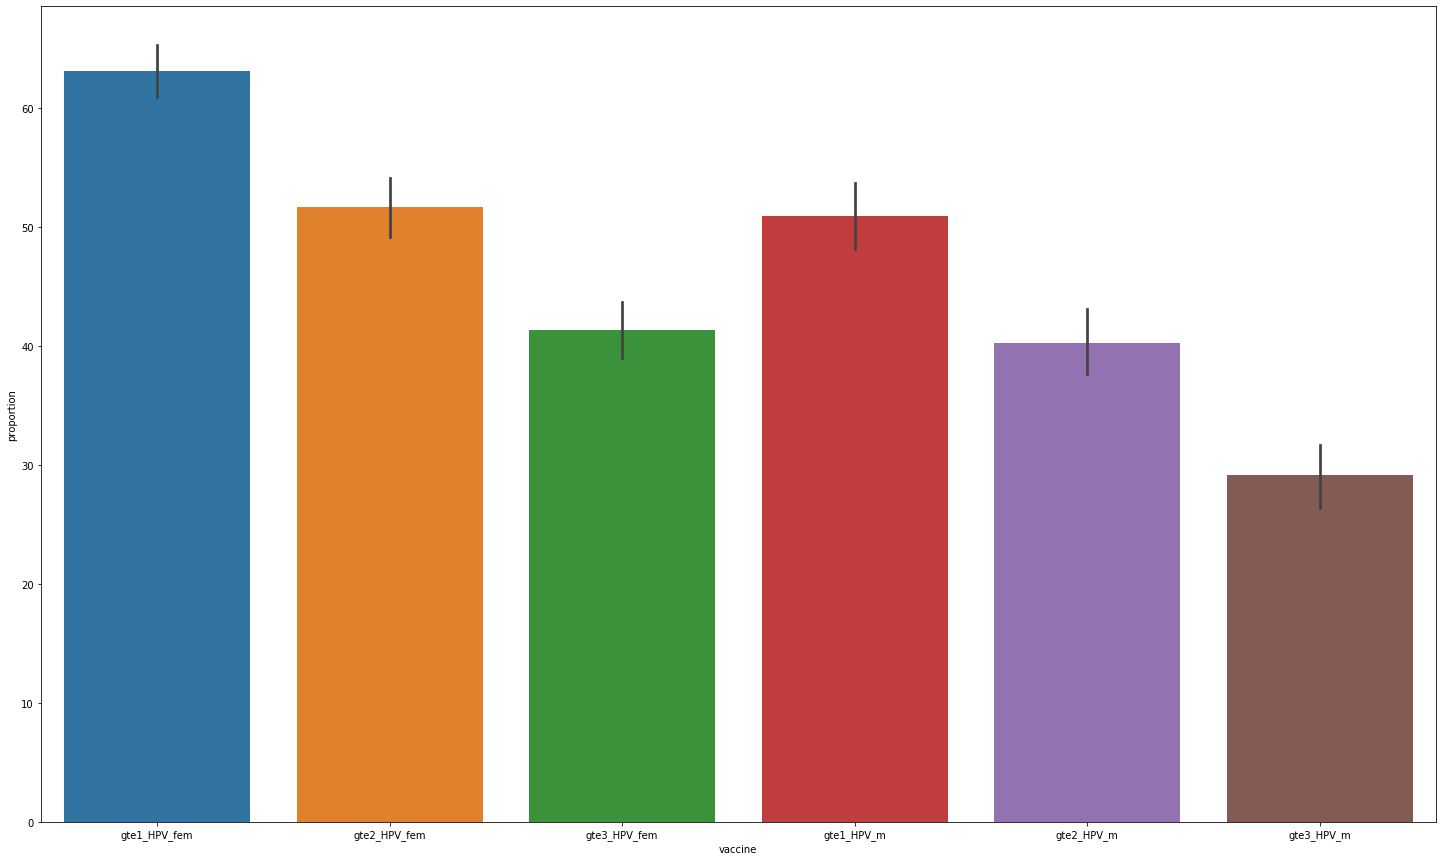

In [10]:
import pandas as pd
import seaborn as sns

data = pd.read_csv('hpv_melt.csv')
sns.barplot(x=data.vaccine, y=data.proportion)

From this plot, we immediately see that the proportion of HPV vaccinations decreases from one round of shots to the next. We also see a large difference between male and female rates.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

gte2HPV_fem v.s. gte2HPV_m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.565e-07 U_stat=2.330e+03
gte1HPV_fem v.s. gte1HPV_m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.262e-08 U_stat=2.360e+03
gte3HPV_fem v.s. gte3HPV_m: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.372e-08 U_stat=2.412e+03


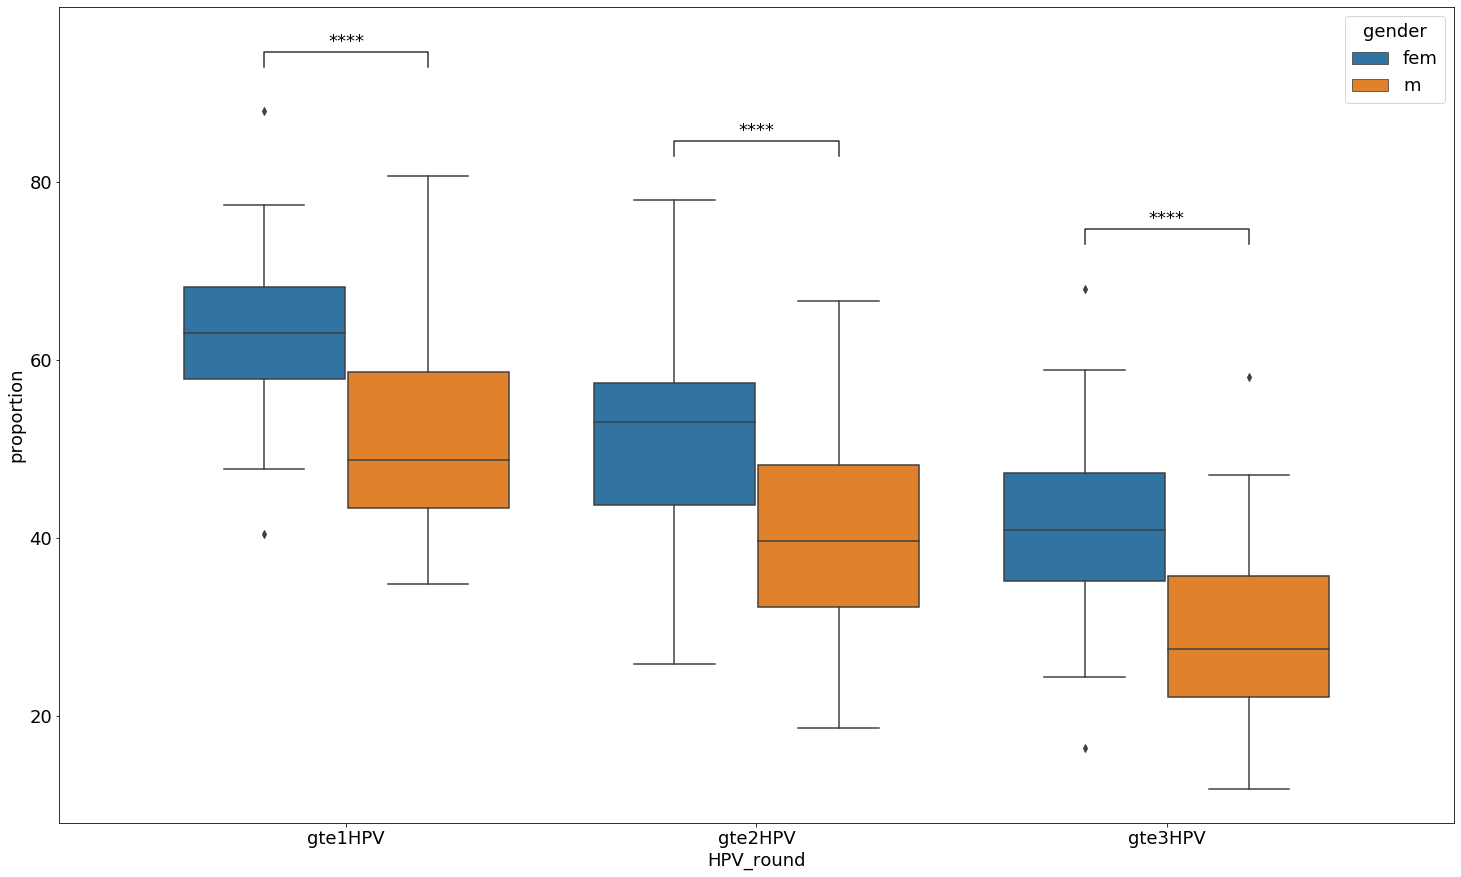

In [49]:
from statannot import add_stat_annotation

melt_hpv = data
melt_hpv['gender'] = melt_hpv.vaccine.apply(lambda x: x.split('_')[-1])
melt_hpv['HPV_round'] = melt_hpv.vaccine.apply(lambda x: "".join(x.split('_')[:-1]))
order = list(set(melt_hpv.HPV_round))
boxpairs = [((order[0], 'fem'), (order[0], 'm')),
            ((order[1], 'fem'), (order[1], 'm')),
            ((order[2], 'fem'), (order[2], 'm'))]
ax = sns.boxplot(x="HPV_round", y="proportion", hue="gender", data=melt_hpv)
res = add_stat_annotation(ax, data=melt_hpv, x="HPV_round", y="proportion", hue="gender", 
                          box_pairs=boxpairs, test='Mann-Whitney', loc='inside')

We can also see that differences between male and female proportions from one round to the next are also statistically significant.

### Comparing to Education Data

We first load the data from https://nces.ed.gov/programs/digest/d19/tables/dt19_203.40.asp?current=yes to obtain current enrollment information. This will be used to standardize spending and other statewide metrics on a per-pupil basis.

Total expenditures per state can be found here https://nces.ed.gov/programs/digest/d19/tables/dt19_236.30.asp?current=yes. In the following cells, the data from these 2 sources will be combined to show how HPV vaccination rates correlates to per-pupil education spending.

In [20]:
# Get total enrollment across states and territories after a little data cleaning
enrollment = pd.read_csv('enrollment.csv', header=None)
# standardize names
enrollment[0] = [i.strip().split('..')[0].strip() for i in enrollment[0]]

expenditures = pd.read_csv('expenditures.csv', header=None, index_col=0)
expenditures.index = [i.strip().split('..')[0].strip() for i in expenditures.index]
expenditures.iloc[:,0] = [int(str(i).replace(',','')) for i in expenditures.iloc[:,0]]
expenditures['enrollment'] = [int(str(i).replace(',','')) for i in enrollment.iloc[:,1]]
expenditures['CostPerStudent'] = expenditures.iloc[:,0] / expenditures.iloc[:,1]
expenditures.columns = ['expenditures', 'enrollment', 'CostPerStudent']
expenditures = expenditures.sort_index()
expenditures.sort_values(by='CostPerStudent').head()

,expenditures,enrollment,CostPerStudent
Puerto Rico,2891749,346096,8.355338
Idaho,2560406,301186,8.501079
Utah,5813157,668274,8.698763
Oklahoma,6228822,695092,8.961148
Arizona,10530826,1110851,9.479963


/Users/simonelongo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


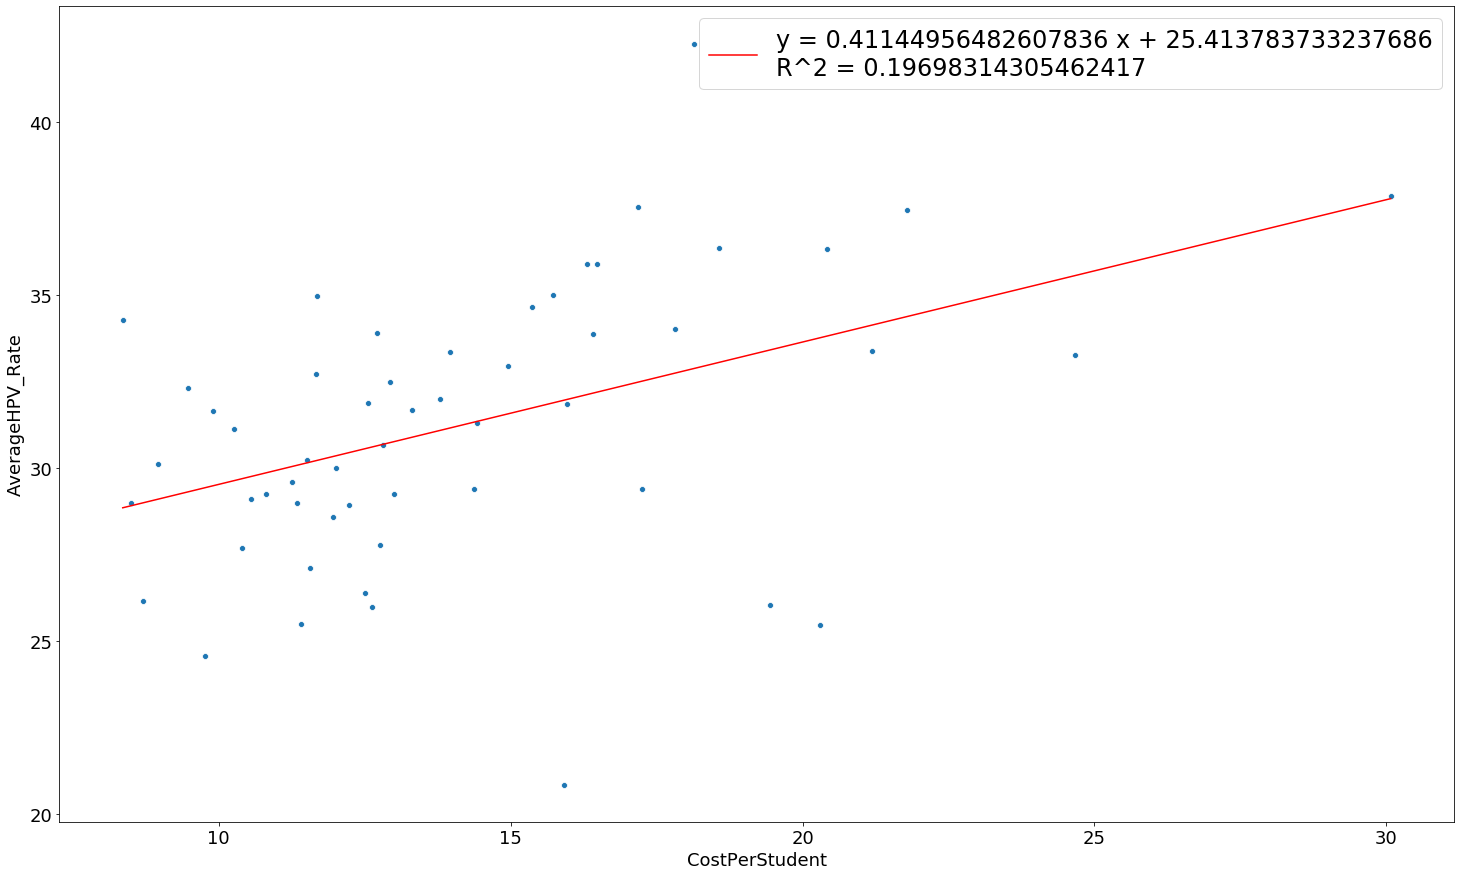

In [50]:
df =pd.read_csv('hpv_clean_w_err.csv', index_col=0)
df.columns = ['State', *df.columns[1:]]
df = df.set_index('State')
hpv = df.iloc[:,3:9]
hpv['AverageHPV_Rate'] = df.mean(axis=1)
hpv = hpv.sort_index()
sns.scatterplot(y=hpv.AverageHPV_Rate, x=expenditures.CostPerStudent)
plot_trendline(y=hpv.AverageHPV_Rate, x=expenditures.CostPerStudent)

We see some weak correlation between higher spending per-pupil and higher HPV vaccination rates. This evidence is further validated by examining sexual education requirements. 

The following sexual education data was taken from https://www.guttmacher.org/state-policy/explore/sex-and-hiv-education.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NotRequired v.s. Required: Custom statistical test, P_val:2.747e-02


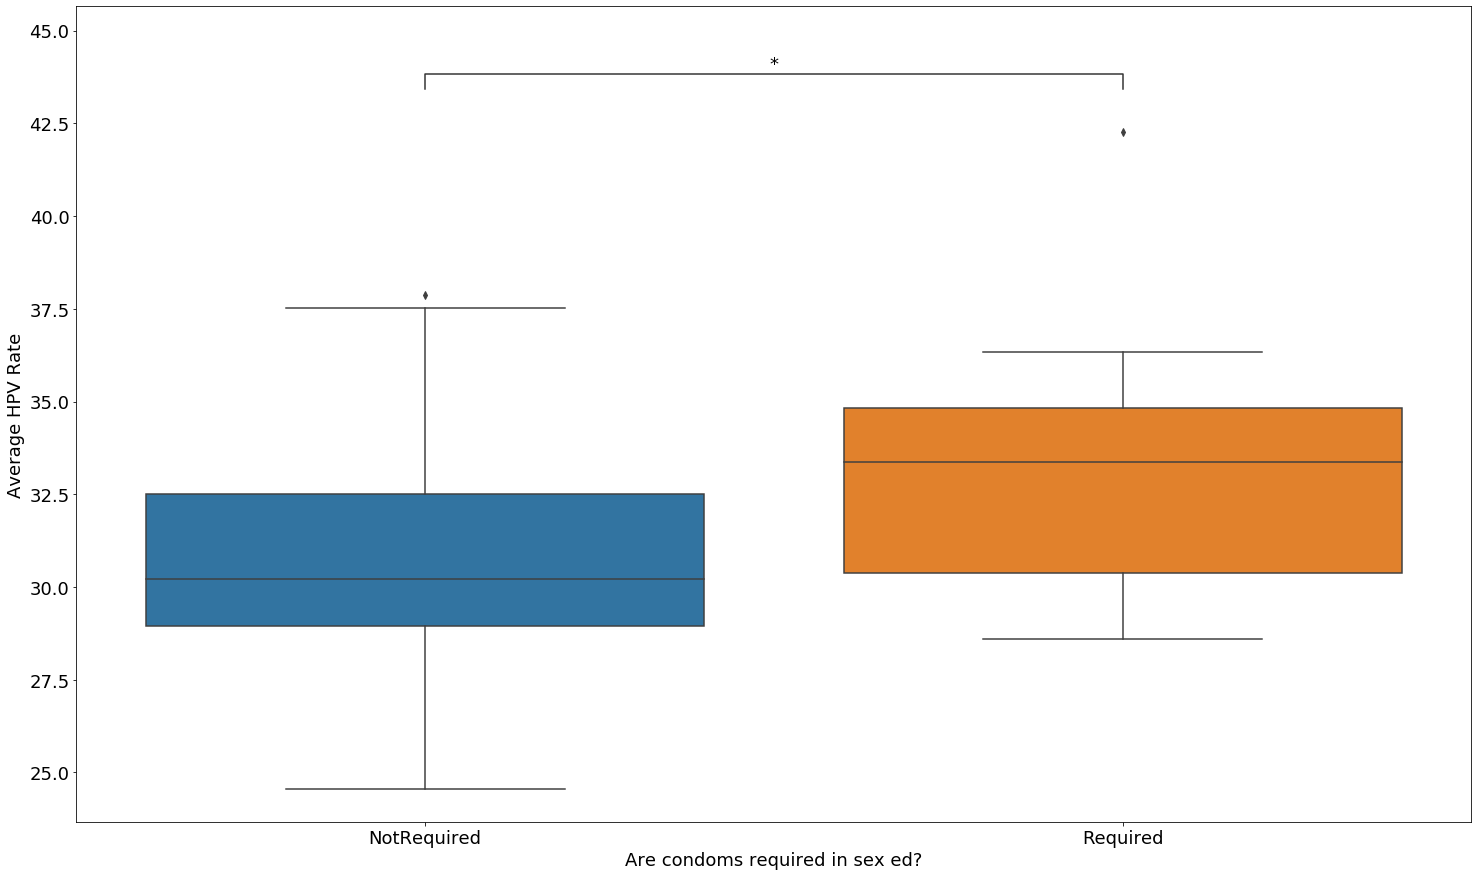

In [51]:
cdm = pd.read_csv('condoms.csv', header=None, index_col=0)
cdm[2] = [hpv.loc[x, 'AverageHPV_Rate'] for x in cdm.index]
#sns.boxplot(cdm[1], cdm[2])
cdm.columns = ['Required', 'AverageHPV_Rate']
mww_2g(cdm[cdm.Required == 0].AverageHPV_Rate, cdm[cdm.Required == 1].AverageHPV_Rate, 
       names=['NotRequired', 'Required'], col_names=['Average HPV Rate', 'Are condoms required in sex ed?'])

In [43]:
# Some helper functions

from statsmodels.formula.api import ols
import numpy as np
from scipy.stats import mannwhitneyu as mww
import itertools as it

def plot_trendline(x, y, c='r'):
    data = {'x':x, 'y':y}
    model = ols("y ~ x", data=data)
    results = model.fit()
    m = results.params[1]
    b = results.params[0]
    xax = np.linspace(x.min(), x.max(), 100)
    yax = m * xax + b
    plt.plot(xax, yax,  c, label='y = {} x + {}\nR^2 = {}'.format(m, b, results.rsquared))
    plt.legend(fontsize=24)
    plt.show()
    
def mww_2g(g1, g2, names=None, col_names=['Value', 'Variable']):
    if names is None:
        name1 = g1.name
        name2 = g2.name
    else:
        name1 = names[0]
        name2 = names[1]

    order = [name1, name2]
    boxpairs = [(name1, name2)]
    stat, pvalue = mww(g1, g2)
    
    df = pd.DataFrame(zip(g1, it.repeat(name1)))
    df = df.append(pd.DataFrame(zip(g2, it.repeat(name2))))
    df.columns = col_names
    plt.figure()
    ax = sns.boxplot(data=df, x=col_names[1], y=col_names[0], order=order)
    res = add_stat_annotation(ax, data=df, x=col_names[1], y=col_names[0], 
                              box_pairs=boxpairs, perform_stat_test=False, pvalues=[pvalue],
                              test_short_name='Mann-Whitney-Wilcoxon', text_format='star', verbose=2, loc='inside')